<a href="https://colab.research.google.com/github/andreavitaletti/colab/blob/main/programming_differential_privacy/notebooks/chap3_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original: https://desfontain.es/blog/differential-privacy-in-practice.html

#[A definition of Differential Privacy](https://desfontain.es/blog/differential-privacy-in-more-detail.html)

![](https://upload.wikimedia.org/wikipedia/commons/d/db/Differential_privacy_informal_definition.png)


<!-- $$ \mathbb{P}\left[A(D_1)=O\right] \le e^\varepsilon\cdot\mathbb{P}\left[A(D_2)=O\right] $$ -->

![](https://upload.wikimedia.org/wikipedia/commons/3/3a/Differential_privacy_formal_definition.png)

# Have you consumed illegal drugs in the past week?

If you naively go out and ask people whether they're using illegal drugs, many will lie to you, furthermor you want to preserve a level of privacy that makes participant confident that their personal informatino will not be revealed. So you conceive the Algorithm A, described in the following block diagram. It takes in input each participant in the dataset $D_1$ ad counts the number of people in the dataset that consumed illegal drugs.



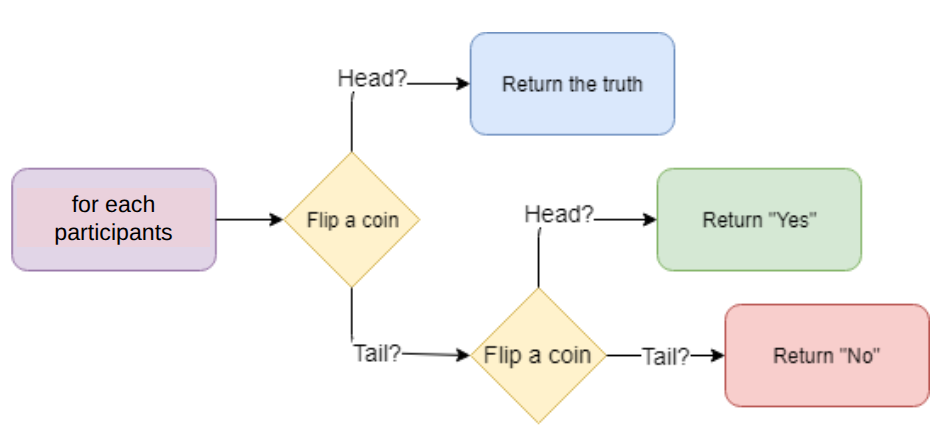

They can now answer Yes without revealing that they're doing something illegal. When someone answers Yes, you can't know their true answer for sure. They could be actually consuming drugs, but they might also have answered at random.

Let's compute the probabilities of each answer **for a drug user.**
With probability 50%, they will say the truth and answer Yes.
With probability 50%, they will answer at random.
They then have another 50% chance to answer Yes, so 25% chance in total.
Similarly, in total, they have a 25% chance to answer No.

For a drug user: 75% chance to answer Yes and a 25% chance to answer No.

For someone who is not consuming drugs, the probabilities are reversed: 25% chance to answer Yes and 75% to answer No.

$P[A(Yes) = Yes]=0.75$ , $P[A(Yes) = No]=0.25$ i.e. probability that the algorithm A correctly identifies the drug users (YES) is 0.75%

$P[A(No) = Yes]=0.25$ , $P[A(No) = No]=0.75$

0.75 is three times bigger than 0.25. So if we choose ε such as $e^\epsilon=3$ (that's ε≃1.1), this algorithm A is ε-differentially private

# This process introduces noise

Of course, with a differentially private process like this one, you're getting some noise (random answers) into your data.
But if you have enough answers, with high probability, the noise will cancel itself out.




What if you want more privacy? Instead of having the participants say the truth with probability 50%, you can have them tell the truth 25% of the time. What if you want less noise instead, at the cost of less protection? Have them tell the truth 75% of the time

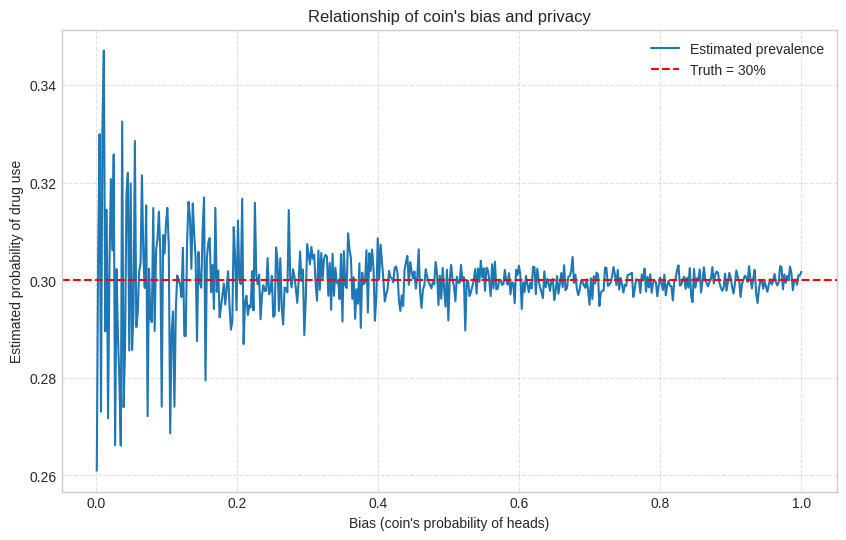

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
true_rate = 0.3   # true proportion of drug users
n = 2000          # participants per experiment
repeats = 50      # repetitions for averaging (reduce randomness)

bias_values = np.linspace(0.001, 1, 500)  # bias range (avoid 0 to prevent div/0)
estimates = []

for q in bias_values:
    run_estimates = []
    for _ in range(repeats):
        # Ground truth population
        population = np.random.rand(n) < true_rate
        responses = []

        for person in population:
            if np.random.rand() < q:
                # First coin = heads → answer truthfully
                responses.append(person)
            else:
                # First coin = tails → answer random using second biased coin
                responses.append(np.random.rand() < q)

        observed_yes = np.mean(responses)

        # Debiasing formula:
        # E[yes] = q*p + (1-q)*q  → solve for p
        if q != 0:
            est_p = (observed_yes - (1 - q) * q) / q
            run_estimates.append(est_p)

    estimates.append(np.mean(run_estimates))

# Plot
plt.figure(figsize=(10,6))
plt.plot(bias_values, estimates, linewidth=1.5, label="Estimated prevalence")
plt.axhline(true_rate, color="red", linestyle="--", label="Truth = 30%")
plt.xlabel("Bias (coin's probability of heads)")
plt.ylabel("Estimated probability of drug use")
plt.title("Relationship of coin's bias and privacy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# Attacker's perspective

We have a mechanism A  which is ε-differentially private. We run it on some database D, and release the output A(D) to an attacker. Then, the attacker tries to figure out whether someone (the target) is in D.

Let's take the stronger attacker we can think of: he/she knows all the database, except their target. This attacker has to determine which database is the real one, between two options:
* $D_{in}$ which contains the target in it
* $D_{out}$ which does not coniatin the target in it

in the attacker's model of the world, the actual database D can be either $D_{in}$ or $D_{out}$


The attacker has an intial suspicioun that the target is in the database $P[D=Din]$


Observing the output $A(D)=O$, he/she updates this suspicion $P[D=Din∣A(D)=O]$

For the example above, with $ϵ = 1.1$ we have

![](https://desfontain.es/blog/images/dp-bounds-graph.svg)

for an initial suspicion of 50%, the updated suspicion is approximately between 25% and 75%.

More in general we have the following graph for different values of ϵ

![](https://desfontain.es/blog/images/dp-contour-graph.png)

# Counting unique users

Suppose you have a database, and you want to publish how many people in there satisfy a given condition. Say, how many are 40 ?

You can't just publish the true answer. Let's take a moment to understand why.

**With differential privacy, we assume that the attacker knows almost all elements. They only have uncertainty about their target.** Say they want to know whether their target is 40. If you output the real number k
, they can compare it with the number of people with age 40 among the people they know. If it's k−1, then the target is 40. If it's k, then the target does not.

So, what do we do? We compute the exact answer, and **we add noise**. This noise will come from a probability distribution called the Laplace distribution. This distribution has a parameter, its scale, which determines how "flat" it is. It looks like this:

![](https://desfontain.es/blog/images/laplace-ln-3.svg)


Graph showing a Laplace distribution with scale 1/ln($\epsilon$), centered on 0
So, to get $\epsilon$-differential privacy, we pick a random value according to Laplace(1/$\epsilon$), and we add this noise to the real value.

Why does it work? Let's look at the distribution of the number we return, depending on whether the true count is k=1000 (blue line, the target isn't 40) or k=1001 (yellow line, the target is 40).

![](https://desfontain.es/blog/images/two-laplace-ln-3.svg)

Graph showing two Laplace distributions with scale 1/ln($\epsilon$), centered on 1000 and 1001
Let's say the real number is k=1001
, and after adding noise, we published 1003
. Let's put ourselves in the attacker's shoes. What's the likelihood that the original number was 1001
 vs. 1000
? The hypothesis "k=1001
" is a bit more likely: generating a noise of 2
 is more likely than a noise of 3
. How much more likely? It turns out that the ratio between these likelihoods is... $e^\epsilon$.! So the ratio of probabilities of differential privacy is satisfied.

This works no matter what the output is: the ratio will always be between eε
 and $e^\epsilon$.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
adult = pd.read_csv("https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_with_pii.csv")

PDF for x = 0.0: 0.5


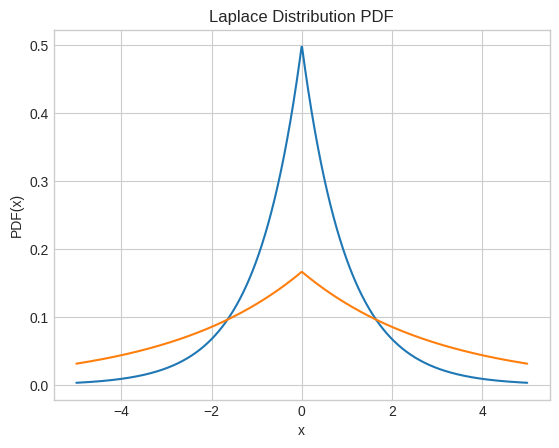

In [46]:
from scipy import stats

# Define location (mean) and scale parameters
loc = 0
scale = 1.0
scale1 = 3.0

# Create a Laplace distribution object
laplace_dist = stats.laplace(loc, scale)
laplace_dist1 = stats.laplace(loc, scale1)

# Calculate the PDF for a specific value (x = 3.0)
x = 0.0
pdf_value = laplace_dist.pdf(x)

print(f"PDF for x = {x}: {pdf_value}")

# Alternatively, calculate the PDF for an array of values
x_values = np.linspace(-5.0, 5.0, 1000)
pdf_values = laplace_dist.pdf(x_values)
pdf_values1 = laplace_dist1.pdf(x_values)

# Plot the PDF (using matplotlib)
import matplotlib.pyplot as plt

plt.plot(x_values, pdf_values)
plt.plot(x_values, pdf_values1)
plt.xlabel("x")
plt.ylabel("PDF(x)")
plt.title("Laplace Distribution PDF")
plt.show()

In [47]:
adult[adult['Age'] == 40].shape[0]

514

In [48]:
sensitivity = 1
epsilon = 0.1

adult[adult['Age'] == 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

514.1711237922705

In [49]:
forties = adult[adult['Age'] == 40]
forties.head(10)

,Name,DOB,SSN,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
41,Theo Fearney,1/22/1983,439-28-9935,95683,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,<=50K,40,0,0
64,Rebeka Casali,9/23/1983,789-15-5786,16447,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,<=50K,40,0,0
130,Lucienne Bjerkan,7/22/1983,291-44-4348,90907,NaN,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,40,United-States,<=50K,40,0,0
159,Rodina Lawlings,4/21/1983,103-24-4654,63643,Self-emp-not-inc,Some-college,10,Separated,Sales,Unmarried,Black,Male,2,United-States,<=50K,40,0,1816
168,Faustine Harris,8/13/1983,470-53-4203,83031,Federal-gov,Assoc-acdm,12,Never-married,Exec-managerial,Not-in-family,White,Male,42,United-States,<=50K,40,0,0
238,Leanna Conor,8/20/1983,798-82-1662,38496,State-gov,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,38,United-States,<=50K,40,0,0
254,Sampson Deboick,7/27/1983,347-52-7988,32825,Local-gov,10th,6,Widowed,Other-service,Unmarried,Black,Female,30,United-States,<=50K,40,0,0
267,Kerwin O'Keefe,9/11/1983,453-01-6150,69315,Self-emp-inc,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,75,Thailand,>50K,40,0,0
282,Melessa Franceschelli,3/13/1983,886-19-8474,70124,Private,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,15,Germany,<=50K,40,0,0
302,Randolph Renihan,10/13/1983,497-37-9432,22079,Private,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,40,United-States,>50K,40,7688,0


# How Much Noise is Enough?

How do we know that the Laplace mechanism adds enough noise to prevent the re-identification of individuals in the dataset? For one thing, we can try to break it! Let's write down a malicious counting query, which is specifically designed to determine whether Melessa Franceschelli is 40: the query returns 1 is she is 40

In [58]:
melissa_row = adult[adult['Name'] == 'Melessa Franceschelli']
melissa_row[melissa_row['Age'] == 40].shape[0]

1

This result definitely violates Melissa's privacy, since it reveals the value of the age column for Melissa's row. Since we know how to ensure differential privacy for counting queries with the Laplace mechanism, we can do so for this query:

In [57]:
sensitivity = 1
epsilon = 0.1

melissa_row = adult[adult['Name'] == 'Melessa Franceschelli']
melissa_row[melissa_row['Age'] == 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

5.373104941055159

Is the true answer 0 or 1? There's too much noise to be able to reliably tell. This is how differential privacy is intended to work - the approach does not reject queries which are determined to be malicious; instead, it adds enough noise that the results of a malicious query will be useless to the adversary.

**Randomness and Replicability**

This example uses randomized algorithms, particularly when demonstrating differentially private mechanisms that add noise to data or model updates. Because we do not fix a random seed, the exact output of these examples will vary from one run to another. This variability is expected and is a natural consequence of differential privacy, which depends on randomness to provide protection.

If your results differ slightly from those shown in the book, that’s not a bug—it’s a feature. The underlying behavior of the algorithm should remain consistent, even if the exact numbers vary. If you need to replicate results exactly (for testing or debugging), you can set a fixed seed using tools like `np.random.seed()` or `random.seed()` in Python. For instructional purposes, however, we choose not to fix seeds so that the examples reflect the true behavior of private algorithms in practice.


# Counting things

OK, so counting unique users was pretty easy. Counting things must also be straightforward, right? Let's say you have a database of suggestions that people sent to your company using a feedback form.

You want to publish the number of suggestions you received on a given day. Meanwhile, the attacker wants to get an idea of how many complaints their target published.

What's different about the previous scenario? Can't we just add noise picked from Laplace(1/ε) and get ε-differential privacy?

There's a catch: **what if someone sent more than one complaint during one day?** Let's say someone was super unhappy and sent five complaints. The other 1000 customers sent one complaint each. The influence of this one disgruntled customer will be larger than before. The two distributions now look like this:

![](https://desfontain.es/blog/images/two-laplace-ln-3-interval-5.svg)

Graph showing two Laplace distribution with scale 1/ln(ε), centered on 1000 and 1005.

The difference between the curves is much larger than before. Their ratio is at most $e^{5\epsilon}$, so using a parameter of 1/ε only gives 5ε-differential privacy.

To fix this, we need to add more noise. How much more? It depends on the maximum contribution of one individual user. If the maximum amount of complaints in one day is 5, you must add 5 times the amount of noise. In this example, using Laplace(5/ε) would give you ε-differential privacy.

![](https://desfontain.es/blog/images/two-laplace-5-ln-3.svg)

Graph showing two Laplace distribution with scale 5/ln(ε), centered on 1000 and 1005

<mark>Note that you can't fully automate this process: you need to know what the largest contribution can be. A human, with some knowledge over the process, must make a judgment call. </mark> In our case, this could be "users won't post more than five complaints per day".

What happens if that judgment call is wrong, and a user later decides to post 10 complaints in one day? To preserve the desired level of privacy, you need to clamp all values to the estimated maximum. In other words, for this outlier user, you would only count 5 complaints in the non-noisy sum.

This process can introduce unexpected bias in the data. So, be careful when estimating the largest contribution! If clamping only happens very rarely, you should be fine.

# Summing or averaging numbers

Let's say each of your users gives your customer service a rating, between -10 and 10. You want to release the average rating. Computing an average is pretty much the same as computing a sum — add all ratings, then divide by the number of users. So, what do we do to the sum to achieve differential privacy?

Among all rating options, we only have to consider the worst possible case. How far can the two noise curves be from each other? If the values are all between -10 and 10, the greatest possible difference is 10−(−10)=20
. It happens when the attacker tries to determine whether a user voted -10 or 10.

Like in the previous example, you have to add noise of Laplace(20/ε)
 to get ε -differential privacy. And just as before, you need to check that each value is between your theoretical minimum and maximum. If you find an anomalous value, e.g. lower than the minimum, you need to clamp it to the minimum before adding it to the sum.

In some cases, estimating these minimum or maximum values is difficult. For example, if you're computing the average salary in a large group of people, how should you estimate the upper salary limit? I don't see that problem as a usability flaw of differential privacy. Rather, it suggests that averages are not a meaningful metric in the presence of outliers. Removing these outliers is a good idea for both accuracy and privacy :-)

# [Releasing many things at once](https://desfontain.es/blog/differential-privacy-in-practice.html)